# Simulation and parameter recovery of dynamic foraging task.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from aind_behavior_gym.dynamic_foraging.task import CoupledBlockTask
from aind_dynamic_foraging_models.generative_model import ForagerCollection

## Get all foragers

In [36]:
forager_collection = ForagerCollection()
df = forager_collection.get_all_foragers()
df.columns

Index(['agent_class_name', 'agent_kwargs', 'agent_alias',
       'number_of_learning_rate', 'number_of_forget_rate', 'choice_kernel',
       'action_selection', 'preset_name', 'n_free_params', 'params', 'forager',
       'win_stay_lose_switch'],
      dtype='object')

In [37]:
df[["agent_class_name", "preset_name", "n_free_params", "params"]]

agent_class_name          preset_name  n_free_params  \
0          ForagerQLearning                 None              3   
1          ForagerQLearning      Rescorla-Wagner              3   
2          ForagerQLearning                 None              4   
3          ForagerQLearning                 None              4   
4          ForagerQLearning                 None              5   
5          ForagerQLearning                 None              5   
6          ForagerQLearning                 None              4   
7          ForagerQLearning                 None              4   
8          ForagerQLearning             Bari2019              5   
9          ForagerQLearning                 None              5   
10         ForagerQLearning                 None              6   
11         ForagerQLearning                 None              6   
12         ForagerQLearning                 None              4   
13         ForagerQLearning                 None              4   
14         ForagerQLearning                 None              5   
15         ForagerQLearning                 None              5   
16         ForagerQLearning                 None              6   
17         ForagerQLearning                 None              6   
18         ForagerQLearning          Hattori2019              5   
19         ForagerQLearning                 None              5   
20         ForagerQLearning                 None              6   
21         ForagerQLearning                 None              6   
22         ForagerQLearning                 None              7   
23         ForagerQLearning                 None              7   
24      ForagerLossCounting                 None              3   
25      ForagerLossCounting                 None              4   
26      ForagerLossCounting                 None              5   
27      ForagerLossCounting  Win-Stay-Lose-Shift              1   
28      ForagerLossCounting                 None              2   
29      ForagerLossCounting                 None              3   
30  ForagerCompareThreshold   CompareToThreshold              4   
31  ForagerCompareThreshold                 None              5   
32  ForagerCompareThreshold                 None              6   

                                               params  
0                            $\alpha$, $b_L$, $\beta$  
1                         $\alpha$, $b_L$, $\epsilon$  
2   $\alpha$, $\alpha_{ck}$ (fixed), $w_{ck}$, $b_...  
3   $\alpha$, $\alpha_{ck}$ (fixed), $w_{ck}$, $b_...  
4   $\alpha$, $\alpha_{ck}$, $w_{ck}$, $b_L$, $\beta$  
5   $\alpha$, $\alpha_{ck}$, $w_{ck}$, $b_L$, $\ep...  
6                  $\alpha$, $\delta$, $b_L$, $\beta$  
7               $\alpha$, $\delta$, $b_L$, $\epsilon$  
8   $\alpha$, $\delta$, $\alpha_{ck}$ (fixed), $w_...  
9   $\alpha$, $\delta$, $\alpha_{ck}$ (fixed), $w_...  
10  $\alpha$, $\delta$, $\alpha_{ck}$, $w_{ck}$, $...  
11  $\alpha$, $\delta$, $\alpha_{ck}$, $w_{ck}$, $...  
12     $\alpha_{rew}$, $\alpha_{unr}$, $b_L$, $\beta$  
13  $\alpha_{rew}$, $\alpha_{unr}$, $b_L$, $\epsilon$  
14  $\alpha_{rew}$, $\alpha_{unr}$, $\alpha_{ck}$ ...  
15  $\alpha_{rew}$, $\alpha_{unr}$, $\alpha_{ck}$ ...  
16  $\alpha_{rew}$, $\alpha_{unr}$, $\alpha_{ck}$,...  
17  $\alpha_{rew}$, $\alpha_{unr}$, $\alpha_{ck}$,...  
18  $\alpha_{rew}$, $\alpha_{unr}$, $\delta$, $b_L...  
19  $\alpha_{rew}$, $\alpha_{unr}$, $\delta$, $b_L...  
20  $\alpha_{rew}$, $\alpha_{unr}$, $\delta$, $\al...  
21  $\alpha_{rew}$, $\alpha_{unr}$, $\delta$, $\al...  
22  $\alpha_{rew}$, $\alpha_{unr}$, $\delta$, $\al...  
23  $\alpha_{rew}$, $\alpha_{unr}$, $\delta$, $\al...  
24                   $\mu_{LC}$, $\sigma_{LC}$, $b_L$  
25  $\mu_{LC}$, $\sigma_{LC}$, $\alpha_{ck}$ (fixe...  
26  $\mu_{LC}$, $\sigma_{LC}$, $\alpha_{ck}$, $w_{...  
27   $\mu_{LC}$ (fixed), $\sigma_{LC}$ (fixed), $b_L$  
28  $\mu_{LC}$ (fixed), $\sigma_{LC}$ (fixed), $\a...  
29  $\mu_{LC}$ (fixed), $\sigma_{LC}$ (fixed), $\a..

## Initialize an agent

In [38]:
# Initialize the model
forager = ForagerCollection().get_preset_forager("Hattori2019", seed=42)
forager.set_params(
    softmax_inverse_temperature=5,
    biasL=0,
)

# Create the task environment
task = CoupledBlockTask(reward_baiting=True, num_trials=1000, seed=42)

## Simulation the task

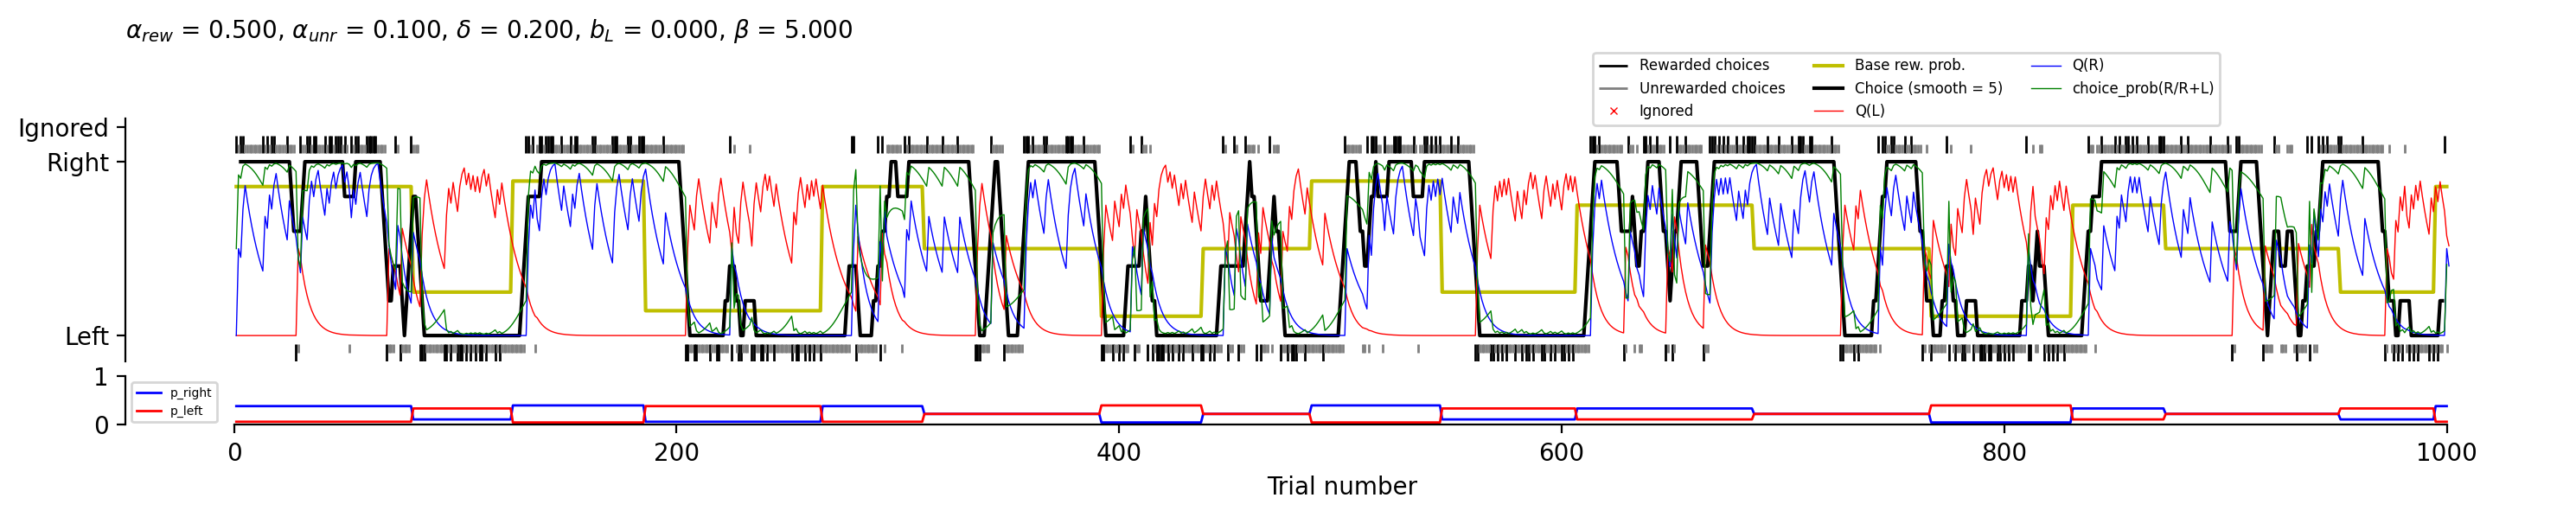

In [39]:
# Run the model
forager.perform(task)

# Capture the results
ground_truth_params = forager.params.model_dump()
ground_truth_choice_prob = forager.choice_prob
ground_truth_q_value = forager.q_value
# Get the history
choice_history = forager.get_choice_history()
reward_history = forager.get_reward_history()

# Plot the session results
fig, axes = forager.plot_session(if_plot_latent=True)

## Parameter Recovery

In [40]:
# Fit the model to recover parameters
forager = ForagerCollection().get_preset_forager("Hattori2019", seed=42)
forager.fit(
    choice_history,
    reward_history,
    fit_bounds_override={"softmax_inverse_temperature": [0, 100]},
    clamp_params={"biasL": 0},
    DE_kwargs=dict(workers=4, disp=True, seed=np.random.default_rng(42)),
    k_fold_cross_validation=2,
)

fitting_result = forager.fitting_result

2025-07-14 12:31:15,945 - aind_dynamic_foraging_models.generative_model.base - INFO - Fitting the model using the whole dataset...
2025-07-14 12:31:15,945 - aind_dynamic_foraging_models.generative_model.base - INFO - Fitting the model using the whole dataset...
2025-07-14 12:31:15,945 - aind_dynamic_foraging_models.generative_model.base - INFO - Fitting the model using the whole dataset...
2025-07-14 12:31:15,945 - aind_dynamic_foraging_models.generative_model.base - INFO - Fitting the model using the whole dataset...
2025-07-14 12:31:15,945 - aind_dynamic_foraging_models.generative_model.base - INFO - Fitting the model using the whole dataset...


differential_evolution step 1: f(x)= 289.0829807952948
differential_evolution step 2: f(x)= 289.0829807952948
differential_evolution step 3: f(x)= 281.81494935346745
differential_evolution step 4: f(x)= 281.81494935346745
differential_evolution step 5: f(x)= 274.5302899183117
differential_evolution step 6: f(x)= 269.50581117373895
differential_evolution step 7: f(x)= 269.50581117373895
differential_evolution step 8: f(x)= 268.8194903533564
differential_evolution step 9: f(x)= 268.8194903533564
differential_evolution step 10: f(x)= 266.7927553904235
differential_evolution step 11: f(x)= 263.6466546216352
differential_evolution step 12: f(x)= 262.19320851442285
differential_evolution step 13: f(x)= 261.2331468139508
differential_evolution step 14: f(x)= 260.82392337795153
differential_evolution step 15: f(x)= 260.82392337795153
differential_evolution step 16: f(x)= 259.7272308092718
differential_evolution step 17: f(x)= 259.7272308092718
differential_evolution step 18: f(x)= 259.72723080

2025-07-14 12:31:29,114 - aind_dynamic_foraging_models.generative_model.base - INFO - Cross-validating the model using 2-fold cross-validation...
2025-07-14 12:31:29,114 - aind_dynamic_foraging_models.generative_model.base - INFO - Cross-validating the model using 2-fold cross-validation...
2025-07-14 12:31:29,114 - aind_dynamic_foraging_models.generative_model.base - INFO - Cross-validating the model using 2-fold cross-validation...
2025-07-14 12:31:29,114 - aind_dynamic_foraging_models.generative_model.base - INFO - Cross-validating the model using 2-fold cross-validation...
2025-07-14 12:31:29,114 - aind_dynamic_foraging_models.generative_model.base - INFO - Cross-validating the model using 2-fold cross-validation...
2025-07-14 12:31:29,115 - aind_dynamic_foraging_models.generative_model.base - INFO - Cross-validation fold 1/2...
2025-07-14 12:31:29,115 - aind_dynamic_foraging_models.generative_model.base - INFO - Cross-validation fold 1/2...
2025-07-14 12:31:29,115 - aind_dynamic_f

differential_evolution step 1: f(x)= 135.31441247407474
differential_evolution step 2: f(x)= 135.31441247407474
differential_evolution step 3: f(x)= 134.11728814996712
differential_evolution step 4: f(x)= 134.11728814996712
differential_evolution step 5: f(x)= 134.11728814996712
differential_evolution step 6: f(x)= 133.65116948610572
differential_evolution step 7: f(x)= 133.65116948610572
differential_evolution step 8: f(x)= 131.5135943487673
differential_evolution step 9: f(x)= 131.5135943487673
differential_evolution step 10: f(x)= 131.5135943487673
differential_evolution step 11: f(x)= 130.79701542268816
differential_evolution step 12: f(x)= 130.79701542268816
differential_evolution step 13: f(x)= 130.79701542268816
differential_evolution step 14: f(x)= 130.5614354968586
differential_evolution step 15: f(x)= 130.5614354968586
differential_evolution step 16: f(x)= 130.4882255741939
differential_evolution step 17: f(x)= 130.4882255741939
differential_evolution step 18: f(x)= 130.48822

2025-07-14 12:31:39,561 - aind_dynamic_foraging_models.generative_model.base - INFO - Cross-validation fold 2/2...
2025-07-14 12:31:39,561 - aind_dynamic_foraging_models.generative_model.base - INFO - Cross-validation fold 2/2...
2025-07-14 12:31:39,561 - aind_dynamic_foraging_models.generative_model.base - INFO - Cross-validation fold 2/2...
2025-07-14 12:31:39,561 - aind_dynamic_foraging_models.generative_model.base - INFO - Cross-validation fold 2/2...
2025-07-14 12:31:39,561 - aind_dynamic_foraging_models.generative_model.base - INFO - Cross-validation fold 2/2...


differential_evolution step 1: f(x)= 135.10124354478836
differential_evolution step 2: f(x)= 133.1199773324392
differential_evolution step 3: f(x)= 133.1199773324392
differential_evolution step 4: f(x)= 131.06476689834454
differential_evolution step 5: f(x)= 131.06476689834454
differential_evolution step 6: f(x)= 131.06476689834454
differential_evolution step 7: f(x)= 129.32398678390223
differential_evolution step 8: f(x)= 128.542556906244
differential_evolution step 9: f(x)= 127.07641721142232
differential_evolution step 10: f(x)= 125.93625659620062
differential_evolution step 11: f(x)= 125.93625659620062
differential_evolution step 12: f(x)= 124.85860970643273
differential_evolution step 13: f(x)= 124.85860970643273
differential_evolution step 14: f(x)= 124.85860970643273
differential_evolution step 15: f(x)= 124.85860970643273
differential_evolution step 16: f(x)= 124.85860970643273
differential_evolution step 17: f(x)= 124.85860970643273
differential_evolution step 18: f(x)= 124.81

In [41]:
# Check fitted parameters
fit_names = fitting_result.fit_settings["fit_names"]
ground_truth = [num for name, num in ground_truth_params.items() if name in fit_names]
print(f"Num of trials: {len(choice_history)}")
print(f"Fitted parameters: {fit_names}")
print(f'Ground truth: {[f"{num:.4f}" for num in ground_truth]}')
print(f'Fitted:       {[f"{num:.4f}" for num in fitting_result.x]}')
print(f"Likelihood-Per-Trial: {fitting_result.LPT}")
print(f"Prediction accuracy full dataset: {fitting_result.prediction_accuracy}\n")

Num of trials: 1000
Fitted parameters: ['learn_rate_rew', 'learn_rate_unrew', 'forget_rate_unchosen', 'softmax_inverse_temperature']
Ground truth: ['0.5000', '0.1000', '0.2000', '5.0000']
Fitted:       ['0.6010', '0.1087', '0.1544', '4.8908']
Likelihood-Per-Trial: 0.7732456884816687
Prediction accuracy full dataset: 0.902



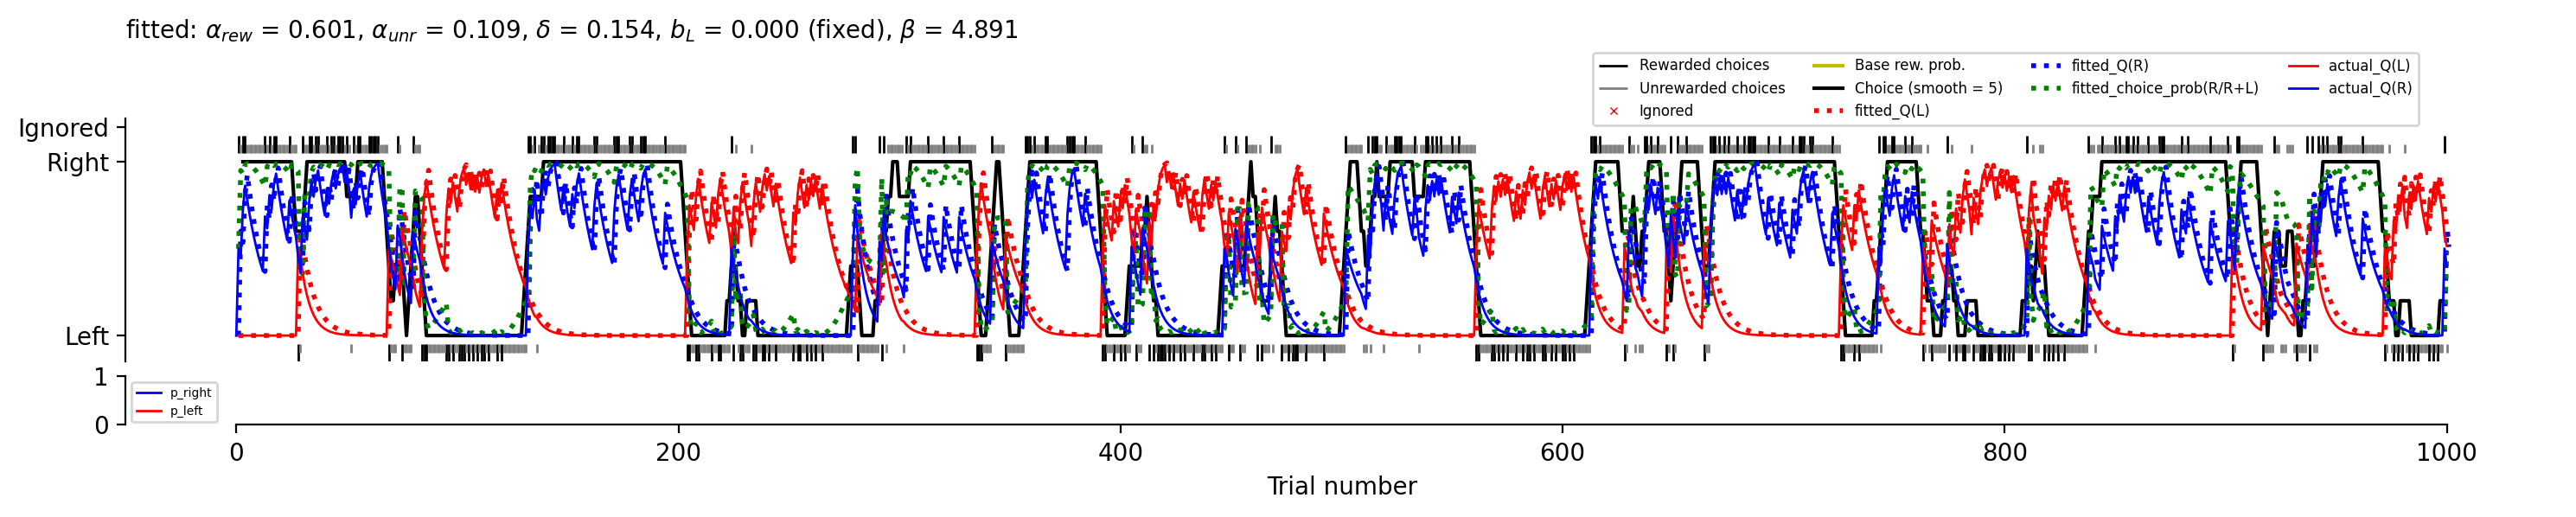

In [42]:
# Plot the fitted session results
fig_fitting, axes = forager.plot_fitted_session(if_plot_latent=True)

# Overlay the ground truth Q-values for comparison
axes[0].plot(ground_truth_q_value[0], lw=1, color="red", ls="-", label="actual_Q(L)")
axes[0].plot(ground_truth_q_value[1], lw=1, color="blue", ls="-", label="actual_Q(R)")
axes[0].legend(fontsize=6, loc="upper left", bbox_to_anchor=(0.6, 1.3), ncol=4)

In [43]:
forager.get_fitting_result_dict().keys()

dict_keys(['fit_settings', 'params', 'log_likelihood', 'AIC', 'BIC', 'LPT', 'LPT_AIC', 'LPT_BIC', 'k_model', 'n_trials', 'nfev', 'nit', 'success', 'population', 'population_energies', 'params_without_polishing', 'log_likelihood_without_polishing', 'prediction_accuracy', 'fitted_latent_variables', 'cross_validation'])

In [44]:
forager.get_fitting_result_dict()["cross_validation"].keys()

dict_keys(['prediction_accuracy_test', 'prediction_accuracy_fit', 'prediction_accuracy_test_bias_only', 'LPT_test', 'LPT_fit', 'fitting_results_each_fold'])

## Multi-Session Fitting

In this section, we demonstrate how to fit models across multiple sessions.

Key differences from single-session fitting:
- Input data is provided as a **list of arrays** (one per session)
- The model assumes parameters are shared across sessions
- Cross-validation can be performed at the session level
- Results include session-level metrics

In [2]:
def simulate_multi_sessions(
    forager_preset: str,
    ground_truth_params: dict,
    session_lengths: list,
    base_seed: int = 42,
):
    """Simulate multiple sessions with the same parameters but different lengths."""
    choice_history_sessions = []
    reward_history_sessions = []
    choice_prob_sessions = []

    for i, n_trials in enumerate(session_lengths):
        forager = ForagerCollection().get_preset_forager(forager_preset, seed=base_seed + i)
        forager.set_params(**ground_truth_params)

        task = CoupledBlockTask(num_trials=n_trials, seed=base_seed + i * 100, reward_baiting=True)
        forager.perform(task)

        choice_history_sessions.append(np.asarray(forager.choice_history))
        reward_history_sessions.append(np.asarray(forager.reward_history))
        choice_prob_sessions.append(forager.choice_prob.copy())

    session_info = {
        "forager_preset": forager_preset,
        "ground_truth_params": ground_truth_params,
        "session_lengths": session_lengths,
        "n_sessions": len(session_lengths),
        "total_trials": sum(session_lengths),
        "choice_prob_sessions": choice_prob_sessions,
    }

    return choice_history_sessions, reward_history_sessions, session_info

### Example 1: Fitting Multiple Sessions (Without Cross-Validation)

Let's simulate 3 sessions with different lengths and fit the Hattori2019 model across all sessions.

In [3]:
# Ground truth parameters
ground_truth_params = {
    "learn_rate_rew": 0.5,
    "learn_rate_unrew": 0.2,
    "forget_rate_unchosen": 0.1,
    "softmax_inverse_temperature": 8.0,
    "biasL": 0.0,
}

# Simulate multiple sessions
session_lengths = [300, 250, 200]  # 3 sessions with different lengths
choice_sessions, reward_sessions, session_info = simulate_multi_sessions(
    forager_preset="Hattori2019",
    ground_truth_params=ground_truth_params,
    session_lengths=session_lengths,
    base_seed=42,
)

print(f"Simulated {len(session_lengths)} sessions")
print(f"Session lengths: {session_lengths}")
print(f"Total trials: {sum(session_lengths)}")

Simulated 3 sessions
Session lengths: [300, 250, 200]
Total trials: 750


In [4]:
# Fit across multiple sessions
forager = ForagerCollection().get_preset_forager("Hattori2019", seed=123)
fitting_result, _ = forager.fit(
    choice_sessions,  # List of choice history arrays
    reward_sessions,  # List of reward history arrays
    fit_bounds_override={"softmax_inverse_temperature": [0.1, 20]},
    clamp_params={"biasL": 0.0},
    DE_kwargs=dict(workers=4, disp=True, seed=np.random.default_rng(42)),
    k_fold_cross_validation=None,  # No cross-validation
)

2026-01-20 20:24:57,321 - aind_dynamic_foraging_models.generative_model.base - INFO - Fitting the model using the whole dataset...


differential_evolution step 1: f(x)= 176.48864310992087
differential_evolution step 2: f(x)= 170.1508787159623
differential_evolution step 3: f(x)= 170.1508787159623
differential_evolution step 4: f(x)= 170.1508787159623
differential_evolution step 5: f(x)= 170.1508787159623
differential_evolution step 6: f(x)= 170.1508787159623
differential_evolution step 7: f(x)= 169.6948973977089
differential_evolution step 8: f(x)= 169.6948973977089
differential_evolution step 9: f(x)= 169.49792438671022
differential_evolution step 10: f(x)= 169.49792438671022
differential_evolution step 11: f(x)= 169.49792438671022
differential_evolution step 12: f(x)= 169.49792438671022
differential_evolution step 13: f(x)= 169.44986616543474
differential_evolution step 14: f(x)= 169.44986616543474
differential_evolution step 15: f(x)= 168.6781395901898
differential_evolution step 16: f(x)= 168.6781395901898
differential_evolution step 17: f(x)= 168.6781395901898
differential_evolution step 18: f(x)= 168.67813959

In [5]:
# Check fitted parameters
fit_names = fitting_result.fit_settings["fit_names"]
ground_truth = [ground_truth_params.get(name, np.nan) for name in fit_names]

print(f"Number of sessions: {fitting_result.n_sessions}")
print(f"Total trials: {fitting_result.n_trials}")
print(f"\nFitted parameters: {fit_names}")
print(f'Ground truth: {[f"{num:.4f}" for num in ground_truth]}')
print(f'Fitted:       {[f"{num:.4f}" for num in fitting_result.x]}')
print(f"\nLikelihood-Per-Trial: {fitting_result.LPT:.4f}")
print(f"Prediction accuracy: {fitting_result.prediction_accuracy:.4f}")

Number of sessions: 3
Total trials: 750

Fitted parameters: ['learn_rate_rew', 'learn_rate_unrew', 'forget_rate_unchosen', 'softmax_inverse_temperature']
Ground truth: ['0.5000', '0.2000', '0.1000', '8.0000']
Fitted:       ['0.4654', '0.2458', '0.0842', '9.3690']

Likelihood-Per-Trial: 0.7988
Prediction accuracy: 0.9013


2026-01-20 20:27:56,925 - aind_dynamic_foraging_models.generative_model.base - WARNING - plot_fitted_session(if_plot_latent=True) is not supported for multi-session fits. Re-run per-session and plot latent variables session-by-session.


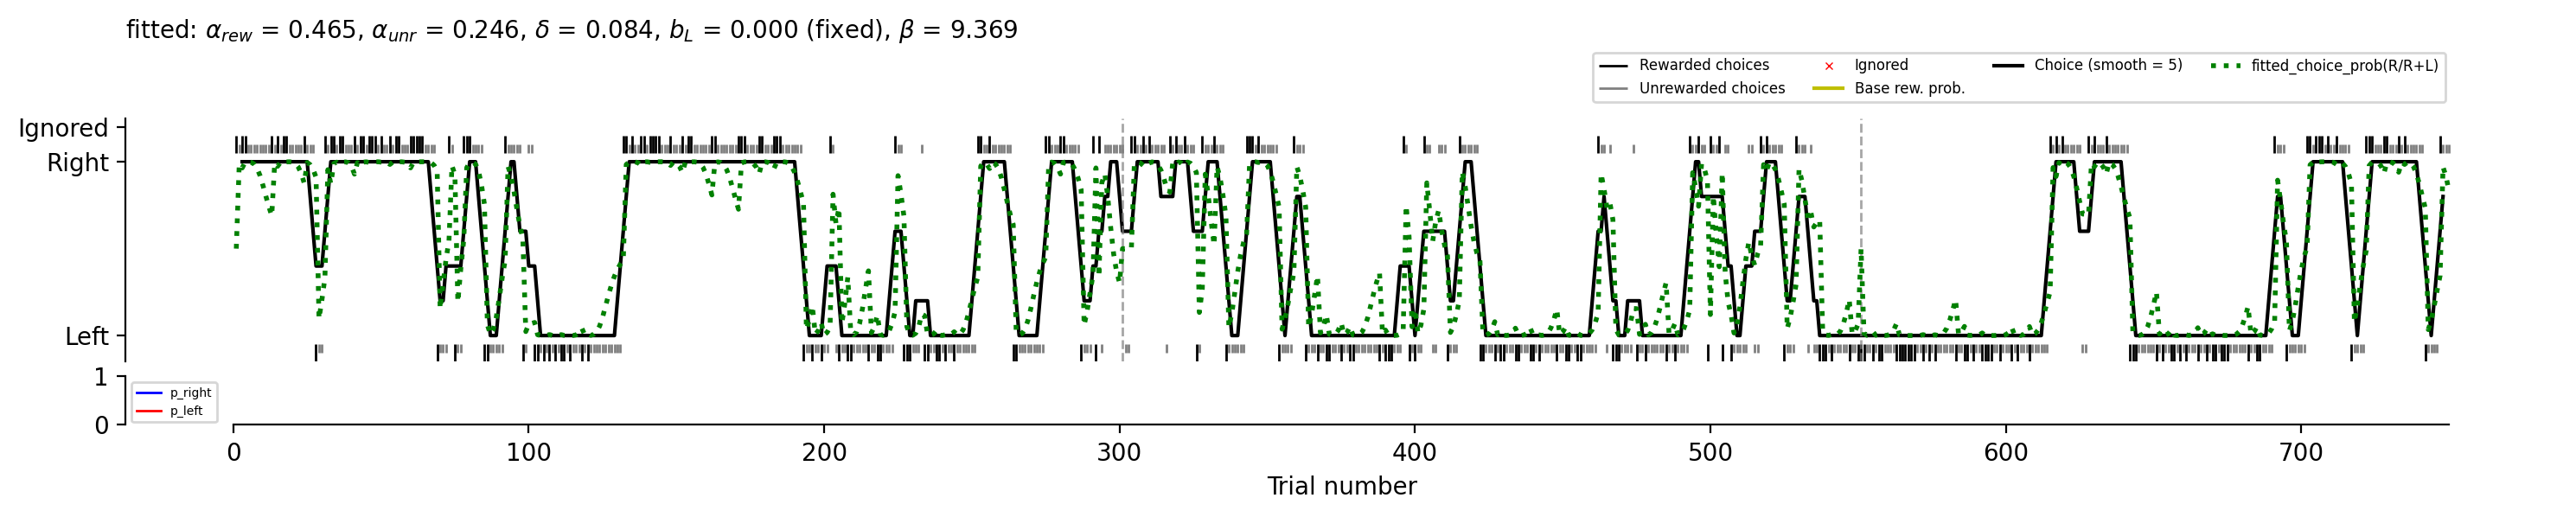

In [7]:
# Plot the multi-session fitting results
fig_fitting, axes = forager.plot_fitted_session(if_plot_latent=True)

### Example 2: Fitting Multiple Sessions with Cross-Validation

Now let's fit the model with k-fold cross-validation at the session level. This helps assess generalization across sessions.

In [8]:
# Simulate more sessions for cross-validation (need at least k sessions for k-fold CV)
session_lengths_cv = [200, 250, 220, 180, 230, 210]  # 6 sessions for 2-fold or 3-fold CV
choice_sessions_cv, reward_sessions_cv, session_info_cv = simulate_multi_sessions(
    forager_preset="Hattori2019",
    ground_truth_params=ground_truth_params,
    session_lengths=session_lengths_cv,
    base_seed=100,
)

print(f"Simulated {len(session_lengths_cv)} sessions for cross-validation")
print(f"Session lengths: {session_lengths_cv}")

Simulated 6 sessions for cross-validation
Session lengths: [200, 250, 220, 180, 230, 210]


In [9]:
# Fit with 3-fold cross-validation
forager_cv = ForagerCollection().get_preset_forager("Hattori2019", seed=456)
fitting_result_cv, fitting_result_cv_dict = forager_cv.fit(
    choice_sessions_cv,
    reward_sessions_cv,
    fit_bounds_override={"softmax_inverse_temperature": [0.1, 20]},
    clamp_params={"biasL": 0.0},
    DE_kwargs=dict(workers=4, disp=True, seed=np.random.default_rng(100)),
    k_fold_cross_validation=3,  # 3-fold session-level CV
)

2026-01-20 20:28:12,963 - aind_dynamic_foraging_models.generative_model.base - INFO - Fitting the model using the whole dataset...


differential_evolution step 1: f(x)= 315.67918784133974
differential_evolution step 2: f(x)= 315.67918784133974
differential_evolution step 3: f(x)= 315.67918784133974
differential_evolution step 4: f(x)= 312.6857967248597
differential_evolution step 5: f(x)= 312.6857967248597
differential_evolution step 6: f(x)= 309.54993659218826
differential_evolution step 7: f(x)= 309.31447430723216
differential_evolution step 8: f(x)= 308.6164380730323
differential_evolution step 9: f(x)= 304.951508648784
differential_evolution step 10: f(x)= 304.951508648784
differential_evolution step 11: f(x)= 304.951508648784
differential_evolution step 12: f(x)= 304.22776313604714
differential_evolution step 13: f(x)= 304.21539817063774
differential_evolution step 14: f(x)= 303.60740064371373
differential_evolution step 15: f(x)= 303.60740064371373
differential_evolution step 16: f(x)= 303.60740064371373
Polishing solution with 'L-BFGS-B'


2026-01-20 20:30:07,385 - aind_dynamic_foraging_models.generative_model.base - INFO - Cross-validating the model using 3-fold cross-validation...
2026-01-20 20:30:07,386 - aind_dynamic_foraging_models.generative_model.base - INFO - Cross-validation fold 1/3...


differential_evolution step 1: f(x)= 204.1300125004323
differential_evolution step 2: f(x)= 204.1300125004323
differential_evolution step 3: f(x)= 203.45244489879812
differential_evolution step 4: f(x)= 203.45244489879812
differential_evolution step 5: f(x)= 203.45244489879812
differential_evolution step 6: f(x)= 203.45244489879812
differential_evolution step 7: f(x)= 203.45244489879812
differential_evolution step 8: f(x)= 203.45244489879812
differential_evolution step 9: f(x)= 202.16585987426814
differential_evolution step 10: f(x)= 200.85697551935147
differential_evolution step 11: f(x)= 200.85697551935147
differential_evolution step 12: f(x)= 200.81450747989004
Polishing solution with 'L-BFGS-B'


2026-01-20 20:31:11,189 - aind_dynamic_foraging_models.generative_model.base - INFO - Cross-validation fold 2/3...


differential_evolution step 1: f(x)= 184.99418434174953
differential_evolution step 2: f(x)= 184.99418434174953
differential_evolution step 3: f(x)= 184.19863175549727
differential_evolution step 4: f(x)= 184.19863175549727
differential_evolution step 5: f(x)= 184.19863175549727
differential_evolution step 6: f(x)= 180.65786515988952
differential_evolution step 7: f(x)= 179.83060107751027
differential_evolution step 8: f(x)= 179.83060107751027
differential_evolution step 9: f(x)= 179.83060107751027
differential_evolution step 10: f(x)= 179.74375912724446
differential_evolution step 11: f(x)= 179.70703410705556
differential_evolution step 12: f(x)= 179.26234507123888
differential_evolution step 13: f(x)= 179.26234507123888
differential_evolution step 14: f(x)= 179.26234507123888
differential_evolution step 15: f(x)= 179.26234507123888
differential_evolution step 16: f(x)= 179.16292655714034
differential_evolution step 17: f(x)= 179.16292655714034
Polishing solution with 'L-BFGS-B'


2026-01-20 20:32:28,910 - aind_dynamic_foraging_models.generative_model.base - INFO - Cross-validation fold 3/3...


differential_evolution step 1: f(x)= 238.09351154145688
differential_evolution step 2: f(x)= 231.75134484988308
differential_evolution step 3: f(x)= 230.5897395573171
differential_evolution step 4: f(x)= 228.58338178698057
differential_evolution step 5: f(x)= 228.58338178698057
differential_evolution step 6: f(x)= 227.92019334532003
differential_evolution step 7: f(x)= 227.26796208067495
differential_evolution step 8: f(x)= 225.83105028732854
differential_evolution step 9: f(x)= 225.72446890092016
differential_evolution step 10: f(x)= 225.72446890092016
differential_evolution step 11: f(x)= 225.38540416007163
differential_evolution step 12: f(x)= 225.38114793816834
differential_evolution step 13: f(x)= 225.38114793816834
differential_evolution step 14: f(x)= 225.38114793816834
differential_evolution step 15: f(x)= 225.38114793816834
Polishing solution with 'L-BFGS-B'


In [10]:
# Check cross-validation results
print(f"Full dataset fitting results:")
print(f"  LPT: {fitting_result_cv.LPT:.4f}")
print(f"  Prediction accuracy: {fitting_result_cv.prediction_accuracy:.4f}")

print(f"\nCross-validation results:")
print(f"  CV Prediction Accuracy (Train): {np.mean(fitting_result_cv_dict['prediction_accuracy_fit']):.4f} (+/- {np.std(fitting_result_cv_dict['prediction_accuracy_fit']):.4f})")
print(f"  CV Prediction Accuracy (Test):  {np.mean(fitting_result_cv_dict['prediction_accuracy_test']):.4f} (+/- {np.std(fitting_result_cv_dict['prediction_accuracy_test']):.4f})")
print(f"  CV LPT (Train): {np.mean(fitting_result_cv_dict['LPT_fit']):.4f}")
print(f"  CV LPT (Test):  {np.mean(fitting_result_cv_dict['LPT_test']):.4f}")

Full dataset fitting results:
  LPT: 0.7904
  Prediction accuracy: 0.9070

Cross-validation results:
  CV Prediction Accuracy (Train): 0.9053 (+/- 0.0088)
  CV Prediction Accuracy (Test):  0.9055 (+/- 0.0191)
  CV LPT (Train): 0.7911
  CV LPT (Test):  0.7874


### Example 3: Comparing Single vs Multi-Session Fitting

Let's compare the parameter recovery when fitting the same data as a single session vs multiple sessions.

In [11]:
# Combine all sessions into a single session
choice_combined = np.concatenate(choice_sessions)
reward_combined = np.concatenate(reward_sessions)

print(f"Combined data: {len(choice_combined)} trials")

# Fit as single session
forager_single = ForagerCollection().get_preset_forager("Hattori2019", seed=789)
fitting_result_single, _ = forager_single.fit(
    choice_combined,
    reward_combined,
    fit_bounds_override={"softmax_inverse_temperature": [0.1, 20]},
    clamp_params={"biasL": 0.0},
    DE_kwargs=dict(workers=4, disp=True, seed=np.random.default_rng(200)),
    k_fold_cross_validation=None,
)

# Fit as multiple sessions (from Example 1)
forager_multi = ForagerCollection().get_preset_forager("Hattori2019", seed=123)
fitting_result_multi, _ = forager_multi.fit(
    choice_sessions,
    reward_sessions,
    fit_bounds_override={"softmax_inverse_temperature": [0.1, 20]},
    clamp_params={"biasL": 0.0},
    DE_kwargs=dict(workers=4, disp=False, seed=np.random.default_rng(42)),
    k_fold_cross_validation=None,
)

# Compare results
print("\nParameter Comparison:")
print(f"{'Parameter':<30} {'Ground Truth':<15} {'Single Session':<15} {'Multi Session':<15}")
print("-" * 75)
for name in fit_names:
    gt_val = ground_truth_params.get(name, np.nan)
    single_val = fitting_result_single.params.get(name, np.nan)
    multi_val = fitting_result_multi.params.get(name, np.nan)
    print(f"{name:<30} {gt_val:<15.4f} {single_val:<15.4f} {multi_val:<15.4f}")

print("\nMetric Comparison:")
print(f"{'Metric':<30} {'Single Session':<15} {'Multi Session':<15}")
print("-" * 60)
print(f"{'LPT':<30} {fitting_result_single.LPT:<15.4f} {fitting_result_multi.LPT:<15.4f}")
print(f"{'Prediction Accuracy':<30} {fitting_result_single.prediction_accuracy:<15.4f} {fitting_result_multi.prediction_accuracy:<15.4f}")

2026-01-20 20:40:22,581 - aind_dynamic_foraging_models.generative_model.base - INFO - Fitting the model using the whole dataset...


Combined data: 750 trials
differential_evolution step 1: f(x)= 171.39551756962288
differential_evolution step 2: f(x)= 169.0361173241277
differential_evolution step 3: f(x)= 169.0361173241277
differential_evolution step 4: f(x)= 169.0361173241277
differential_evolution step 5: f(x)= 169.0361173241277
differential_evolution step 6: f(x)= 169.0361173241277
differential_evolution step 7: f(x)= 168.3502333239067
differential_evolution step 8: f(x)= 168.3502333239067
differential_evolution step 9: f(x)= 168.21019366575655
differential_evolution step 10: f(x)= 168.11626273564906
differential_evolution step 11: f(x)= 168.11626273564906
differential_evolution step 12: f(x)= 167.9454060019542
differential_evolution step 13: f(x)= 167.9454060019542
differential_evolution step 14: f(x)= 167.91915183918746
Polishing solution with 'L-BFGS-B'


2026-01-20 20:41:40,896 - aind_dynamic_foraging_models.generative_model.base - INFO - Fitting the model using the whole dataset...



Parameter Comparison:
Parameter                      Ground Truth    Single Session  Multi Session  
---------------------------------------------------------------------------
learn_rate_rew                 0.5000          0.4635          0.4654         
learn_rate_unrew               0.2000          0.2445          0.2458         
forget_rate_unchosen           0.1000          0.0873          0.0842         
softmax_inverse_temperature    8.0000          9.3423          9.3690         

Metric Comparison:
Metric                         Single Session  Multi Session  
------------------------------------------------------------
LPT                            0.7996          0.7988         
Prediction Accuracy            0.9013          0.9013         


### Accessing Multi-Session Fitting Results

The fitting result dictionary contains additional information for multi-session fits.

In [12]:
# Get the complete fitting result dictionary
result_dict = forager.get_fitting_result_dict()

print("Keys in fitting result dictionary:")
for key in result_dict.keys():
    print(f"  - {key}")

Keys in fitting result dictionary:
  - fit_settings
  - params
  - log_likelihood
  - AIC
  - BIC
  - LPT
  - LPT_AIC
  - LPT_BIC
  - k_model
  - n_trials
  - nfev
  - nit
  - success
  - population
  - population_energies
  - params_without_polishing
  - log_likelihood_without_polishing
  - prediction_accuracy
  - fitted_latent_variables
